In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

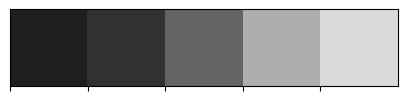

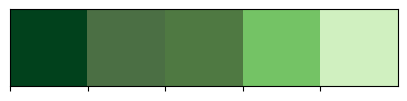

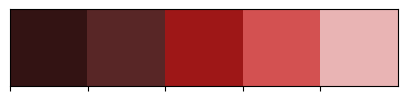

In [4]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [10]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [16]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/miraykaptan


In [18]:
dataset_path = 'Brain-Tumor-Classification-Dataset'
print("Dataset path exists:", os.path.exists(dataset_path))
print("Training path exists:", os.path.exists(os.path.join(dataset_path, 'Training')))
print("Testing path exists:", os.path.exists(os.path.join(dataset_path, 'Testing')))

Dataset path exists: True
Training path exists: True
Testing path exists: True


In [18]:
image_size = 150

In [22]:
X_train = []
y_train = []

# Loop thr Training 
for label in labels:
    folderPath = os.path.join('Brain-Tumor-Classification-Dataset', 'Training', label)
    if os.path.exists(folderPath):  # Check if folder exists
        for img_name in tqdm(os.listdir(folderPath)):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            if img is not None:  # Check if image is successfully read
                img = cv2.resize(img, (image_size, image_size))  # Resize image
                X_train.append(img)  # Add image to training data
                y_train.append(label)  # Add label to training labels
            else:
                print(f"Warning: Failed to load image {img_path}")
    else:
        print(f"Warning: Folder not found {folderPath}")

# Loop thr Testing
for label in labels:
    folderPath = os.path.join('Brain-Tumor-Classification-Dataset', 'Testing', label)
    if os.path.exists(folderPath):  # Check if folder exists
        for img_name in tqdm(os.listdir(folderPath)):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            if img is not None:  # Check if image is successfully read
                img = cv2.resize(img, (image_size, image_size))  # Resize image
                X_train.append(img)  # Add image to training data
                y_train.append(label)  # Add label to training labels
            else:
                print(f"Warning: Failed to load image {img_path}")
    else:
        print(f"Warning: Folder not found {folderPath}")

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)


print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

100%|██████████████████████████████████████████| 74/74 [00:00<00:00, 364.65it/s]


Training data shape: (3264, 150, 150, 3)
Training labels shape: (3264,)


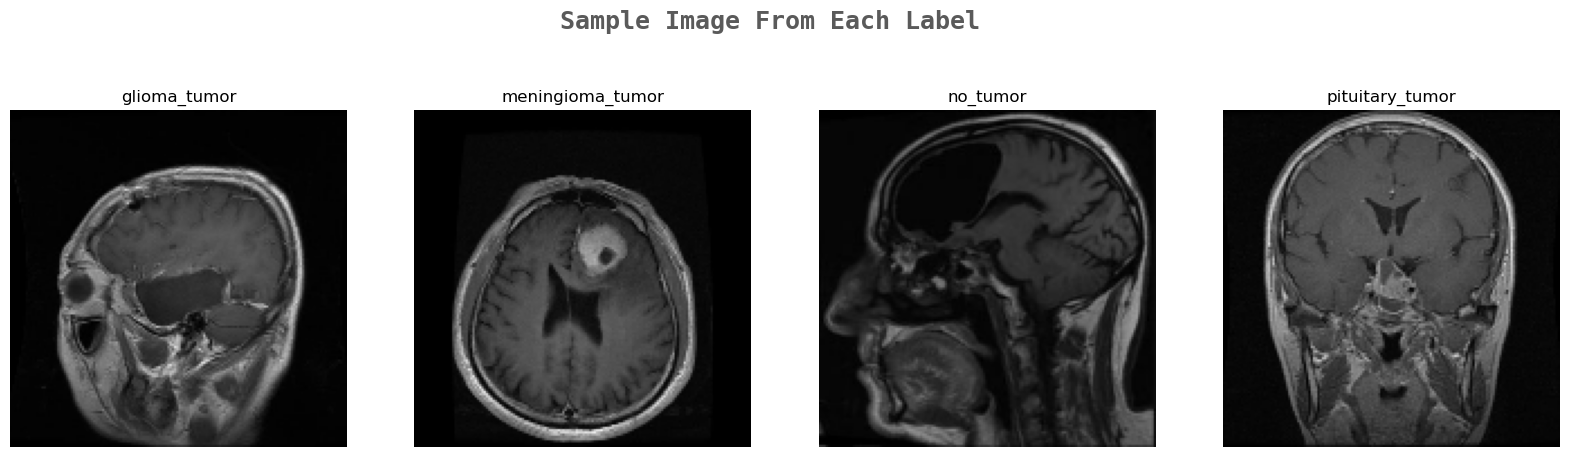

In [24]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [26]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [28]:
X_train.shape

(3264, 150, 150, 3)

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [32]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [34]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [36]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [38]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [40]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [44]:
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# Set up TensorBoard callback
tensorboard = TensorBoard(log_dir='logs')

# Set up ModelCheckpoint callback with the correct file extension
checkpoint = ModelCheckpoint("effnet.keras", 
                              monitor="val_accuracy", 
                              save_best_only=True,
                              mode="auto", 
                              verbose=1)

# Set up ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.3, 
                              patience=2, 
                              min_delta=0.001,
                              mode='auto', 
                              verbose=1)


In [46]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7189 - loss: 0.6939
Epoch 1: val_accuracy improved from -inf to 0.78231, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7201 - loss: 0.6914 - val_accuracy: 0.7823 - val_loss: 0.8271 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9320 - loss: 0.2123
Epoch 2: val_accuracy improved from 0.78231 to 0.82993, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9321 - loss: 0.2120 - val_accuracy: 0.8299 - val_loss: 0.4402 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9543 - loss: 0.1340
Epoch 3: val_accuracy did not improve from 0.82993
83/83 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9543 - loss: 0.1342 - val_accuracy: 0.6667 - val_loss: 0.9315 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9740 - loss: 0.0773
Epoch 4: val_accuracy did not 

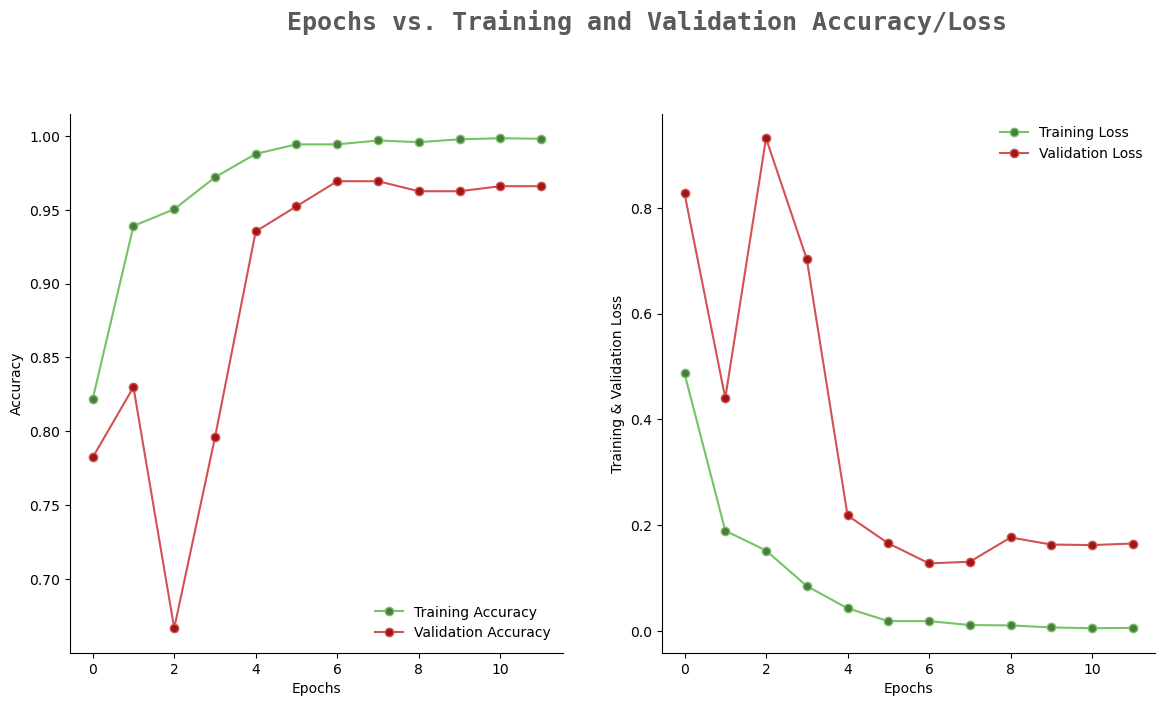

In [48]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [50]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step


In [52]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94        93
           1       0.88      0.99      0.93        95
           2       1.00      0.96      0.98        52
           3       1.00      0.99      0.99        87

    accuracy                           0.96       327
   macro avg       0.97      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



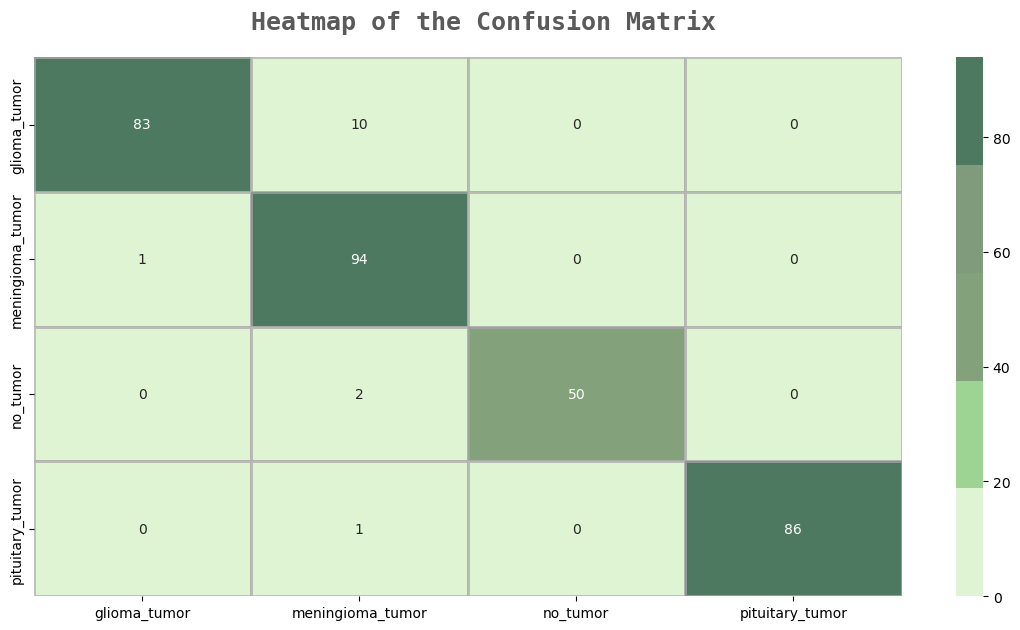

In [54]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()